Let us import the libraries we need to implement the algorithm.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We initialize the square, symmetric tridiagonal matrix that will be used to compute its eigenvalues.

In [ ]:
n = 10
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

a = np.ones(n-1)
b = np.ones(n)*2
A = tridiag(a, b, a)

We verify that the matrix A is indeed symmetric and irreducible.




In [ ]:
# Check if A is symmetric
if (A == A.T).all():
    print("A is symmetric")

A is symmetric


In [ ]:
# Check if A is reducible
irreducible = True
for i in range(A.shape[0]-1):
    if A[i,i+1] == 0:
        irreducible = False
        break
print(f'The matrix is irreducible: {irreducible}')

The matrix is irreducible: True


**Building the Gershgorin circles**

In the following cells, we focus on constructing the Gershgorin circles. The number of circles we obtain is equal to the number of rows in the matrix
A (which is also equal to the number of columns), and their respective centers will be the elements on the main diagonal of
A. Each circle will have its center at the
i-th element of the diagonal, and its radius will be the sum of the absolute values of the elements in the same row as the diagonal element, excluding the absolute value of the diagonal element itself.

In [ ]:
sum_row = []
for i in range(A.shape[0]):
    sum_row.append(sum(np.abs(A[i,:]))-np.abs(A[i,i]))

In [ ]:
sum_row

[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0]

In [ ]:
strictly_diagonally_dominant = True
for i in range(A.shape[0]):
    if np.abs(A[i,i]) == sum_row[i]:
        strictly_diagonally_dominant = False
        break
print(f'The matrix is strictly diagonally dominant: {strictly_diagonally_dominant}')

The matrix is strictly diagonally dominant: False


We can plot the Gershgorin circles

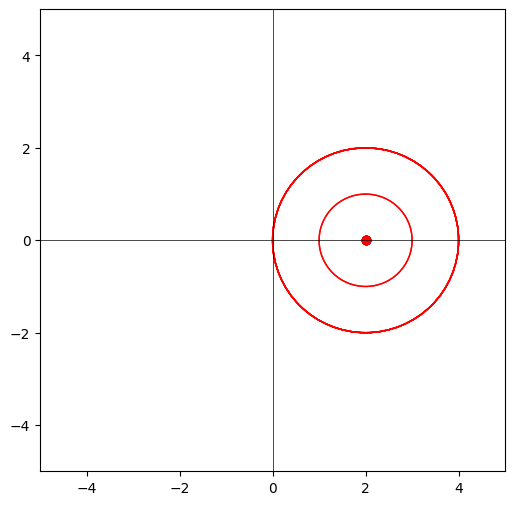

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
for i in range(A.shape[0]):
    center = A[i,i]
    radius = sum_row[i]
    circle = plt.Circle((center.real,center.imag), radius, color='r', fill=False)
    ax.add_artist(circle)
    ax.plot(center.real,center.imag,'ro')
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [ ]:
limits_circle = []
for i in range(A.shape[0]):
    limits_circle.append([A[i,i].real-sum_row[i], A[i,i].real+sum_row[i]])
limits_circle

[[1.0, 3.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [0.0, 4.0],
 [1.0, 3.0]]

In [ ]:
upperbound = np.max(limits_circle)
lowerbound = np.min(limits_circle)

In [ ]:
lowerbound, upperbound

(0.0, 4.0)

According to the properties of Gershgorin circles, we observe that the range of real values in which the eigenvalues of matrix A are located
is [0, 4].

**Computing the eigenvalues**

With the following functions, we can calculate an important quantity that will help us understand how many values fall within a certain interval, which we refer to as *W*.

To define it, we need the characteristic polynomials of increasing degree, i.e., polynomials that range from degree 0 to degree
*n*, where
*n* is the number of eigenvalues. Each polynomial will be evaluated at the same point, and from each one, we will obtain a scalar value with a specific sign.

If we go through the values taken starting from the polynomial of the lowest degree, up to the one of the highest degree, the number of times these values have a different sign from the previous one is equal to *W*.

After giving this mathematical definition of *W*, we can concretely say that, given a value *a* situated within the interval defined by the Gershgorin circles, *W* calculated at this point will be equal to the number of eigenvalues located in the interval [0, *a*] if *a* >= 0.

In [ ]:
def compute_p_n (lamb, n, A):
    if n == 0:
        return 1
    elif n == 1:
        return A[0,0] - lamb
    else:
        return (A[n-1,n-1] - lamb)*compute_p_n(lamb, n-1, A) - A[n-1,n-2]**2*compute_p_n(lamb, n-2, A)

In [ ]:
def compute_derivative_p_n (lamb, n, A):
    if n == 0:
        return 0
    elif n == 1:
        return -1
    else:
        return (A[n-1,n-1] - lamb)*compute_derivative_p_n(lamb, n-1, A) - A[n-1,n-2]**2*compute_derivative_p_n(lamb, n-2, A) -compute_p_n(lamb, n-1, A)

In [ ]:
def compute_W(x, matrix):
    p_n = [compute_p_n(x, i, matrix) for i in range(matrix.shape[0]+1)]
    w = 0
    for i in range(1,len(p_n)):
        j = i-1
        if p_n[i] == 0: #If the current value is zero, skip it because it will take the sign of the previous one and will not change W (i.e., I do not increment it).
            continue
        while p_n[i]*p_n[j] == 0: #If the current value is non-zero, but the previous one is zero, then I decrement j until I find a non-zero value.
            j -= 1
        if p_n[i]*p_n[j] < 0:
            w += 1
    return w

With the function *get_interval*, given the two extremes of the interval identified by the Gershgorin circles and the *k*-th largest eigenvalue, we can calculate the interval in which only the *k*-th largest eigenvalue will be located.

In [ ]:
def get_interval(a, b, k, A):
    while compute_W(b, A) - compute_W(a, A) > 1: # or b-a > 0.0001:
        m = (a+b)/2
        if compute_W(m, A) < A.shape[0]-k+1:
            a = m
        else:
            b = m
    return a,b

We can use this specific interval to extract a point from which the Newton Method can start. Recall that the Newton Method is very sensitive to the initial point, so the interval found by *get_interval* will help us find an initial point that is close enough to the solution.

In [ ]:
def Newton_methon(x0, tol = 1e-9, max_iter = 100):
    x = x0
    x1 = x0
    for i in range(max_iter):
        alpha = 0.01
        x1 = x - compute_p_n(x, A.shape[0], A)/compute_derivative_p_n(x, A.shape[0], A)
        if abs(compute_p_n(x1, A.shape[0], A)) < tol:
            return x1
        x = x1
    return x

Now we can calculate all the eigenvalues with a for loop: for each iteration
*i*, we extract the interval where the
*i*-th eigenvalue will fall, consider the midpoint of that interval as the initial guess for the Newton Method, and then apply the method to compute the eigenvalue.

In [ ]:
eigenvalues = []
for i in range(A.shape[0]):
    a,b = get_interval(lowerbound, upperbound, i+1, A)
    x0 = (a+b)/2
    eigenvalues.append(Newton_methon(x0))
    print(f"Interval for the {i+1} eigenvalue: ({a},{b}) and the eigenvalue is {eigenvalues[-1]}")

Interval for the 1 eigenvalue: (3.75,4.0) and the eigenvalue is 3.918985947228995
Interval for the 2 eigenvalue: (3.5,3.75) and the eigenvalue is 3.6825070656623624
Interval for the 3 eigenvalue: (3.0,3.5) and the eigenvalue is 3.30972146789057
Interval for the 4 eigenvalue: (2.5,3.0) and the eigenvalue is 2.8308300260037726
Interval for the 5 eigenvalue: (2.0,2.5) and the eigenvalue is 2.28462967654657
Interval for the 6 eigenvalue: (1.5,2.0) and the eigenvalue is 1.7153703234534297
Interval for the 7 eigenvalue: (1.0,1.5) and the eigenvalue is 1.1691699739962271
Interval for the 8 eigenvalue: (0.5,1.0) and the eigenvalue is 0.6902785321094298
Interval for the 9 eigenvalue: (0.25,0.5) and the eigenvalue is 0.31749293433763764
Interval for the 10 eigenvalue: (0.0,0.25) and the eigenvalue is 0.08101405277100529
